# Data Science Test 
#### From Luqin REN, 07/16/2022

### Requirements

The dataset consists of two csv files, train.csv and test.csv.  The data can be divided into two
categories as illustrated in the `target` column in the csv files.
Train data has 2700 examples and test data has 900 examples, each data point has 30 attributes and each 
attribute can be either boolean/continuous/discrete values. 


The problem is to train a machine learning model that can differentiate categories for each example in the data.  

## 1. Data Analysis

### 1.1 Data Preparation

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance


dataset = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      2699 non-null   float64
 1   f1      2598 non-null   object 
 2   f2      2700 non-null   object 
 3   f3      2700 non-null   object 
 4   f4      2700 non-null   object 
 5   f5      2700 non-null   object 
 6   f6      2700 non-null   object 
 7   f7      2700 non-null   object 
 8   f8      2700 non-null   object 
 9   f9      2700 non-null   object 
 10  f10     2700 non-null   object 
 11  f11     2700 non-null   object 
 12  f12     2700 non-null   object 
 13  f13     2700 non-null   object 
 14  f14     2700 non-null   object 
 15  f15     2700 non-null   object 
 16  f16     2700 non-null   object 
 17  f17     2424 non-null   float64
 18  f18     2700 non-null   object 
 19  f19     2134 non-null   float64
 20  f20     2700 non-null   object 
 21  f21     2522 non-null   float64
 22  

In [2]:
dataset.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,target
0,49.0,F,t,f,f,f,f,f,f,f,...,72.0,t,0.95,t,76.0,f,NaN,other,3696,positive
1,83.0,F,f,f,f,f,f,f,f,f,...,100.0,t,0.86,t,117.0,f,NaN,SVI,2069,negative
2,57.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,other,851,negative
3,56.0,NaN,f,f,f,f,f,f,f,f,...,86.0,t,0.91,t,95.0,f,NaN,other,2328,negative
4,76.0,F,f,f,f,f,f,f,f,t,...,115.0,t,1.11,t,104.0,f,NaN,SVI,2270,positive


### 1.2 Data Processing 

##### A. Replace Outliers
##### B. Replace NANs
##### C. Encode Categorical Features

### 1.2.1 Label Feature 

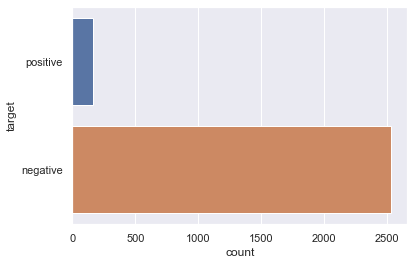

In [3]:
sns.set_theme(style="darkgrid")
ax1 = sns.countplot(y="target", data=dataset)

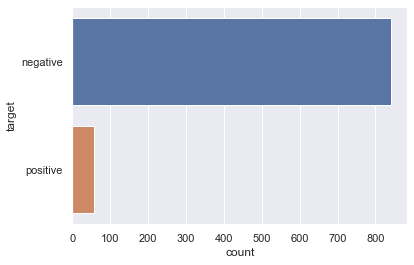

In [4]:
ax2 = sns.countplot(y="target", data=test_set)

The ratio of positive and negative samples in the training set and test set is about **1:15**. The problem of **unbalanced** samples needs to be considered later.

### 1.2.2 Continuous Features 

In [5]:
dataset.describe()

,f0,f17,f19,f21,f23,f25,f27,f29
count,2699.000000,2424.000000,2134.000000,2522.000000,2412.000000,2414.000000,0.0,2700.000000
mean,51.832901,4.682436,2.021228,108.881205,0.997037,110.709983,NaN,1892.355926
std,20.486355,21.616669,0.823985,35.190261,0.193720,32.860272,NaN,1092.537129
min,1.000000,0.005000,0.050000,2.000000,0.310000,2.000000,NaN,1.000000
25%,36.000000,0.450000,1.600000,88.000000,0.880000,93.000000,NaN,952.750000
50%,54.000000,1.400000,2.000000,104.000000,0.980000,107.000000,NaN,1911.000000
75%,67.000000,2.600000,2.400000,125.000000,1.080000,124.000000,NaN,2837.500000
max,455.000000,478.000000,10.600000,430.000000,2.120000,395.000000,NaN,3772.000000


Obviously, the **dimensions** of these continuous variables are different. **Normalization** and **standarization** are required generally.

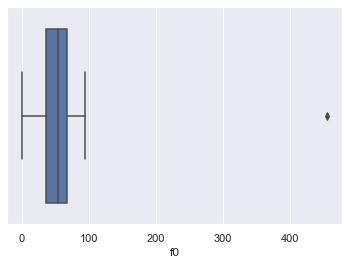

In [6]:
sns.boxplot(x='f0', data=dataset)
dataset.replace(to_replace=455,value=dataset['f0'].mean(),inplace = True)

**f0** looks like 'age', replace **outlier** 455 with mean.

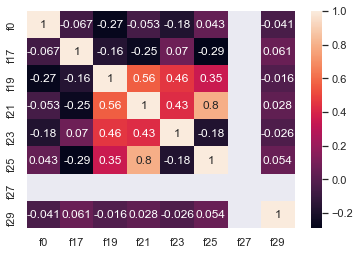

In [7]:
sns.heatmap(dataset.select_dtypes(include='float64').corr(), annot = True)
plt.show()

**f21** and **f25** are strongly correlated, but with **Xgboost**, a tree-based model, can solve the problem of multicollinearity very well, so the step of **PCA** is temporarily omitted here.

### 1.2.3 Categorical Features

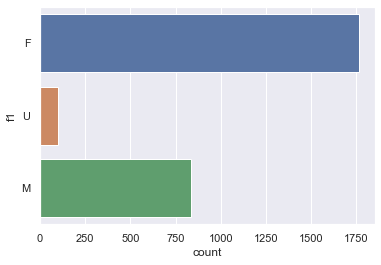

In [8]:
dataset['f1'].fillna(value='U',inplace=True)
ax = sns.countplot(y="f1", data=dataset)

Replace **nan** in Sex feature with U (Unknown)

### 1.2.4 Data Processing Function 

In [9]:
def data_processing(dataset):
    # drop f27 which is all nan
    dataset.drop(columns='f27', inplace = True)
    
    # replace all t with True, and f with False to make them as boolean
    dataset.replace(to_replace='t',value=True,inplace = True)
    dataset.replace(to_replace='f',value=False,inplace = True)
    
    # repalce nan in Sex feature with U to make it categrical
    dataset['f1'].fillna(value='U',inplace=True)
    
    # encode categrical features with labels
    try:
        f1_encoder
    except:
        f1_encoder = LabelEncoder()
    dataset['f1'] = f1_encoder.fit_transform(np.array(dataset['f1']))
    
    try:
        f28_encoder
    except:
        f28_encoder = LabelEncoder()
    dataset['f28'] = f28_encoder.fit_transform(np.array(dataset['f28']))
    
    # replace all nan in continous features with there medians
    for i in dataset.select_dtypes(include='float64').columns:
        dataset[i].fillna(value=dataset[i].median(),inplace=True)

    # replace Y with label 1 and -1
    dataset.replace(to_replace='negative',value=-1,inplace = True)
    dataset.replace(to_replace='positive',value=1,inplace = True)
    
    
    return dataset, f1_encoder, f28_encoder
    
train_set, f1_encoder, f28_encoder  = data_processing(dataset)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      2700 non-null   float64
 1   f1      2700 non-null   int32  
 2   f2      2700 non-null   bool   
 3   f3      2700 non-null   bool   
 4   f4      2700 non-null   bool   
 5   f5      2700 non-null   bool   
 6   f6      2700 non-null   bool   
 7   f7      2700 non-null   bool   
 8   f8      2700 non-null   bool   
 9   f9      2700 non-null   bool   
 10  f10     2700 non-null   bool   
 11  f11     2700 non-null   bool   
 12  f12     2700 non-null   bool   
 13  f13     2700 non-null   bool   
 14  f14     2700 non-null   bool   
 15  f15     2700 non-null   bool   
 16  f16     2700 non-null   bool   
 17  f17     2700 non-null   float64
 18  f18     2700 non-null   bool   
 19  f19     2700 non-null   float64
 20  f20     2700 non-null   bool   
 21  f21     2700 non-null   float64
 22  

### 1.2.5 Data Analysis

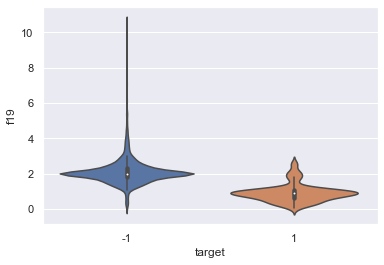

In [10]:
sns.violinplot(x = 'target', y = 'f19', data = train_set)
plt.show()

In the **positive** sample set, **f19** has smaller mean and smaller variance, and it has three peaks, suspected to fit **Gaussian mixture distribution**.
In the **negative** sample set, **f19** is more like a **logarithmic distribution** than a **normal distribution**.

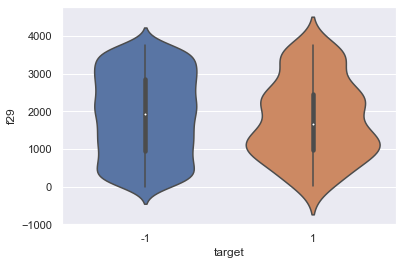

In [11]:
sns.violinplot(x = 'target', y = 'f29', data = train_set)
plt.show()

The distribution of **f29** is different in 2 sample sets.
In the **positive** sample set, the mean of **f29** is smaller and there are three peaks, which are suspected to fit the **Gaussian mixture distribution**.
In the **negative** sample set, **f29** is very close to **uniform distribution**.

## 2. Model Training 

Overall, the dataset is clean and has both continuous and discrete variables. Considering the **simplicity of data processing** and the **training efficiency** and **effect**, here I choose to use the **ensemble** learning method, the **Xgboost** model, to train the data. If the **Xgboost** effect is not good, we can consider using the **Cross Validation** method to compare the effect of other models, such as **RF, SVM, Adaboost**, etc.

## 2.1 Model Training

In [12]:
# split data into X and y
X = train_set[train_set.columns.difference(['target'])]
Y = train_set['target']

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBClassifier(seed=27)
model.fit(X_train, y_train) 

# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score: %.2f%%" % (auc * 100.0))

Accuracy: 98.54%
F1 Score: 88.89%
ROC AUC Score: 93.03%


## 2.2 Model Tunning 

In [13]:
 param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=20, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=10, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X,Y)
gsearch1.best_params_, gsearch1.best_score_

param_test2 = {
 'max_depth':[3,4,5,6,7],
 'min_child_weight':[0.5,1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=20, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=10,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X,Y)
gsearch2.best_params_, gsearch2.best_score_


param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=10,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X,Y)
gsearch3.best_params_, gsearch3.best_score_

param_test5 = {
 'subsample':[i/100.0 for i in range(75,100,5)],
 'colsample_bytree':[i/100.0 for i in range(75,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=10,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X,Y)
gsearch5.best_params_, gsearch5.best_score_

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=10,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X,Y)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9960361266381333)

In [14]:
xgb_final = XGBClassifier(
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1e-5,
 scale_pos_weight=10,
 seed=27)

xgb_final.fit(X_train, y_train) 
# make predictions for test data
y_pred = xgb_final.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score: %.2f%%" % (auc * 100.0))

Accuracy: 98.54%
F1 Score: 89.08%
ROC AUC Score: 93.81%


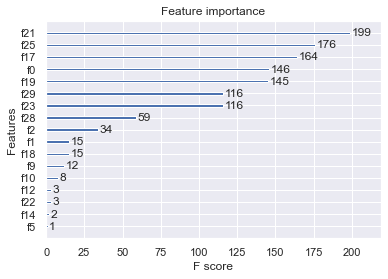

In [15]:
# plot feature importance
plot_importance(xgb_final)
plt.show()

In [16]:
xgb_final.fit(X, Y) 

XGBClassifier(colsample_bytree=0.8, max_depth=5, reg_alpha=1e-05,
              scale_pos_weight=10, seed=27, subsample=0.8)

## 3. Evaluation 

In [17]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      900 non-null    int64  
 1   f1      863 non-null    object 
 2   f2      900 non-null    object 
 3   f3      900 non-null    object 
 4   f4      900 non-null    object 
 5   f5      900 non-null    object 
 6   f6      900 non-null    object 
 7   f7      900 non-null    object 
 8   f8      900 non-null    object 
 9   f9      900 non-null    object 
 10  f10     900 non-null    object 
 11  f11     900 non-null    object 
 12  f12     900 non-null    object 
 13  f13     900 non-null    object 
 14  f14     900 non-null    object 
 15  f15     900 non-null    object 
 16  f16     900 non-null    object 
 17  f17     823 non-null    float64
 18  f18     900 non-null    object 
 19  f19     731 non-null    float64
 20  f20     900 non-null    object 
 21  f21     859 non-null    float64
 22  f2

In [18]:
test_set.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,target
0,30,F,f,f,f,f,t,f,f,f,...,159.0,t,1.65,t,96.0,f,NaN,STMW,1540,negative
1,38,F,f,f,f,f,f,f,f,f,...,57.0,t,0.92,t,63.0,f,NaN,SVHC,1626,negative
2,21,NaN,f,f,f,f,t,f,f,f,...,171.0,t,1.49,t,115.0,f,NaN,STMW,2563,negative
3,50,F,f,f,t,f,f,f,f,f,...,131.0,t,1.02,t,129.0,f,NaN,other,3433,negative
4,66,F,f,f,f,f,f,t,f,f,...,89.0,t,0.87,t,103.0,f,NaN,SVI,1028,negative


In [19]:
test_set, f1_encoder, f28_encoder  = data_processing(test_set)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      900 non-null    int64  
 1   f1      900 non-null    int32  
 2   f2      900 non-null    bool   
 3   f3      900 non-null    bool   
 4   f4      900 non-null    bool   
 5   f5      900 non-null    bool   
 6   f6      900 non-null    bool   
 7   f7      900 non-null    bool   
 8   f8      900 non-null    bool   
 9   f9      900 non-null    bool   
 10  f10     900 non-null    bool   
 11  f11     900 non-null    bool   
 12  f12     900 non-null    bool   
 13  f13     900 non-null    bool   
 14  f14     900 non-null    bool   
 15  f15     900 non-null    bool   
 16  f16     900 non-null    bool   
 17  f17     900 non-null    float64
 18  f18     900 non-null    bool   
 19  f19     900 non-null    float64
 20  f20     900 non-null    bool   
 21  f21     900 non-null    float64
 22  f2

In [20]:
test_set.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f20,f21,f22,f23,f24,f25,f26,f28,f29,target
0,30,0,False,False,False,False,True,False,False,False,...,True,159.0,True,1.65,True,96.0,False,0,1540,-1
1,38,0,False,False,False,False,False,False,False,False,...,True,57.0,True,0.92,True,63.0,False,1,1626,-1
2,21,2,False,False,False,False,True,False,False,False,...,True,171.0,True,1.49,True,115.0,False,0,2563,-1
3,50,0,False,False,True,False,False,False,False,False,...,True,131.0,True,1.02,True,129.0,False,4,3433,-1
4,66,0,False,False,False,False,False,True,False,False,...,True,89.0,True,0.87,True,103.0,False,3,1028,-1


In [21]:
X = test_set[test_set.columns.difference(['target'])]
Y = test_set['target']

# make predictions for test data
y_pred = xgb_final.predict(X)

# evaluate predictions
accuracy = accuracy_score(Y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(Y, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

auc = roc_auc_score(Y, y_pred)
print("ROC AUC Score: %.2f%%" % (auc * 100.0))

Accuracy: 98.67%
F1 Score: 90.00%
ROC AUC Score: 96.08%


# 4. Conclusion

This notebook first processed, cleaned, and preliminarily analyzed the data, and then used the **Xgboost** model to solve the **binary classification** problem. The final **AUC** value on the **test set** can reach **96.08%**.


**Next improvement** directions:
1. Try more diverse feature processing methods
2. Try other ensemble learning methods
3. Upsampling or downsampling for imbalanced sample sets
4. Collect more data